In [69]:
import pandas as pd
import http.client, urllib.parse
import json
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import pyarrow 
import warnings


In [70]:
warnings.simplefilter(action='ignore', category=FutureWarning)

# funcoes

In [71]:
def request_acoes(data_inicial,data_final):
  api_token = 'weZDYsMCoM1rlAGIS7TV9m5bmfHEFmXduI0UAUqu'
  url = 'https://api.stockdata.org/v1/data/eod'

  params = {
      'api_token'  : api_token,
      'symbols'    : 'AAPL,TSLA,AMZN,MSFT,GOOGL,NVDA,META,NFLX,ADBE',
      'limit'      : 5,
      'date_from'  : data_inicial,
      'date_to'    : data_final
  }
  response = requests.get(url, params=params)
  return response.json()


def escrever_json(nome_arquivo, conteudo):
  with open(nome_arquivo, 'w') as f:
    json.dump(conteudo, f, indent=4)


def ler_json(nome_arquivo):
  with open(nome_arquivo, 'r') as f:
    return json.load(f)


# Montando os arquivos

In [72]:
response = request_acoes('2024-12-01','2024-12-11')

In [73]:
lista_acoes          = ['AAPL','TSLA','AMZN','MSFT','GOOGL','NVDA','META','NFLX','ADBE']
df_silver            = pd.DataFrame(response['data'])
df_silver['company'] = lista_acoes * df_silver['date'].nunique()                  # adicionando uma coluna com o nome das variaveis

In [74]:
df_gold          = df_silver.copy()
df_gold['dia']   = pd.to_datetime(df_gold['date']).dt.date
df_gold['preco'] = (df_gold['open'] + df_gold['close']) / 2
df_gold          = df_gold.rename(columns={'company': 'codigo_acao'})
df_gold          = df_gold[['codigo_acao','dia','preco']]


In [75]:
escrever_json('acoes_bronze.json',response['data'])
df_silver.to_parquet('acoes_silver.parquet',engine='pyarrow')
df_gold.to_parquet('acoes_gold.parquet',engine='pyarrow')

# append

emular como seria um append diario

In [76]:
response = request_acoes('2024-12-12','2024-12-12')

In [77]:
acoes_bronze = ler_json('acoes_bronze.json').append(response['data'])

In [78]:
df_bronze_antigo = pd.DataFrame(ler_json('acoes_bronze.json'))
df_bronze_novo   = pd.DataFrame(response['data'])


In [79]:
lista_acoes                = ['AAPL','TSLA','AMZN','MSFT','GOOGL','NVDA','META','NFLX','ADBE']
df_silver_novo             = pd.DataFrame(response['data'])
df_silver_novo['company']  = lista_acoes
df_silver_antigo           = pd.read_parquet('acoes_silver.parquet')
df_silver                  = pd.concat([df_silver_novo,df_silver_antigo])

In [80]:
df_gold_novo          = df_silver_novo.copy()
df_gold_novo['dia']   = pd.to_datetime(df_gold_novo['date']).dt.date
df_gold_novo['preco'] = (df_gold_novo['open'] + df_gold_novo['close']) / 2
df_gold_novo          = df_gold_novo.rename(columns={'company': 'codigo_acao'})
df_gold_novo          = df_gold_novo[['codigo_acao','dia','preco']]
df_gold_antigo        = pd.read_parquet('acoes_gold.parquet')
df_gold               = pd.concat([df_gold_novo,df_gold_antigo])

In [81]:
pd.concat([df_bronze_antigo, df_bronze_novo]).reset_index(drop=True).to_json('acoes_bronze.json')
df_silver.to_parquet('acoes_silver.parquet')
df_gold.to_parquet('acoes_gold.parquet')

# plot

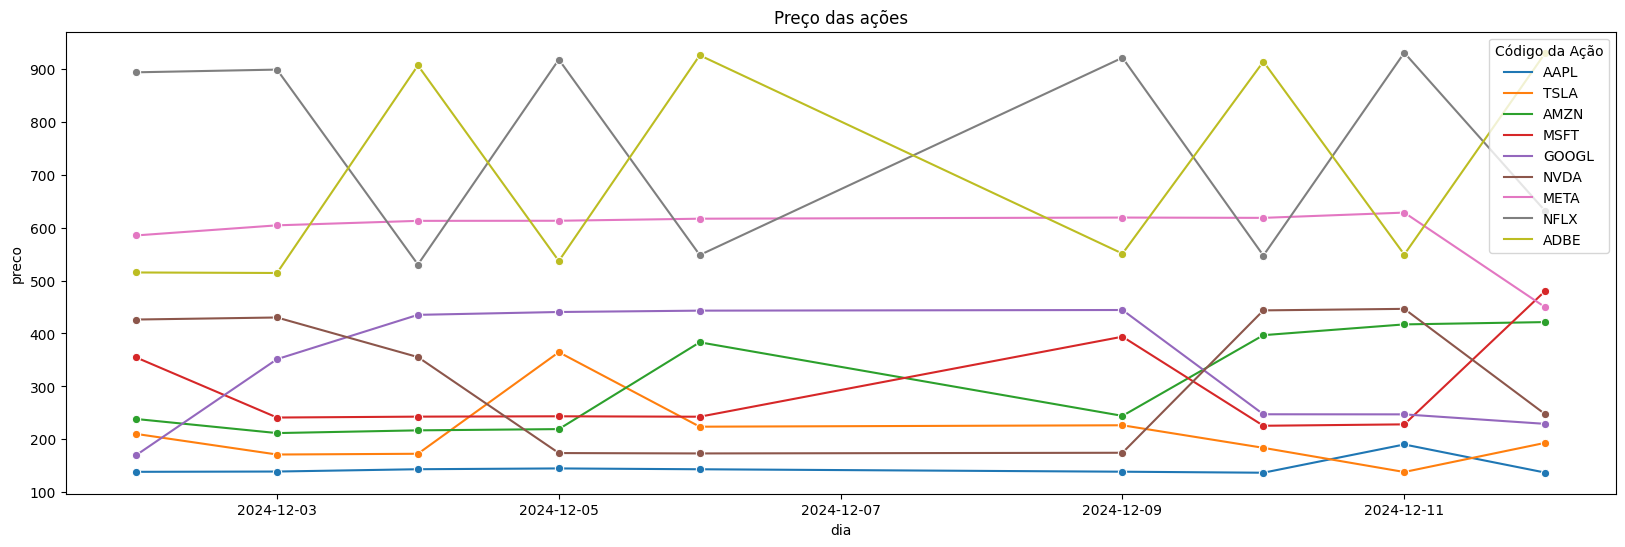

In [82]:
plt.figure(figsize=(20,6))
sns.lineplot(data=df_gold, x='dia', y='preco', hue='codigo_acao', marker='o').set_title("Preço das ações")
plt.legend(title='Código da Ação', loc='upper right')
plt.show()